In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.stats import wilcoxon

# Load the Excel file
file_path = '../data/Dartmouth Data Set- SIRS .xlsx'
excel_data = pd.ExcelFile(file_path)

# # Display sheet names to understand the structure of the file
# sheet_names = excel_data.sheet_names

In [43]:
# Load the "ABC Data" sheet
abc_data = excel_data.parse('ABC Data')

demographics_df = excel_data.parse('Demographics')


In [73]:
# Convert the 'Date Reviewed' column to datetime, ignoring errors
abc_data['Date Reviewed'] = pd.to_datetime(abc_data['Date Reviewed'], errors='coerce')

# Drop rows with invalid or missing dates
cleaned_abc_data = abc_data.dropna(subset=['Date Reviewed'])

merged_df = demographics_df.merge(cleaned_abc_data, on='Local ID', how='inner')



# Categorize race
def categorize_race(race):
    categories = {
        'White': ['White', 'Other: Middle Eastern'],
        'Black/African American': ['Black or African American'],
        'Other/Unknown': ['Unknown, not collected', 'Other', 'Unknown, not collected, White', 'Other: Biracial'],
        'Hispanic/Latinx': ['Other: Hispanic', 'Other: Latino', 'Other: hispanic', 'Other: Mexican'],
        'Asian/Pacific Islander': ['Asian', 'Native Hawaiian or Other Pacific Islander'],
        'Mixed': ['Black or African American, White', 'Asian, White'],
        'American Indian or Alaska Native': ['American Indian or Alaska Native'],
    }

    for category, labels in categories.items():
        if race in labels:
            return category
    return 'Other/Unknown'

# Apply the function to categorize race
merged_df['race_clean'] = merged_df['Race'].apply(categorize_race)


races = merged_df['race_clean'].unique()
behaviors = ['Irritability/Agitation', 'Lethargy/Social Withdrawal', 'Stereotypic Behavior', 'Hyperactivity/Noncompliance', 'Inappropriate Speech']

# Define color mapping for races
colors = {
    'White': ('#1f77b4', '#aec7e8'),
    'Black/African American': ('#ff7f0e', '#ffbb78'),
    'Other/Unknown': ('#2ca02c', '#98df8a'),
    'Hispanic/Latinx': ('#d62728', '#ff9896'),
    'Asian/Pacific Islander': ('#9467bd', '#c5b0d5'),
    'Mixed': ('#8c564b', '#c49c94'),
    'American Indian or Alaska Native': ('#e377c2', '#f7b6d2'),
}

In [74]:
missing_from_demographics = demographics_df[~demographics_df['Local ID'].isin(merged_df['Local ID'])]

# Step 4: Identify rows in filtered_abc_data that are not in merged_df
missing_from_abc_data = cleaned_abc_data[~cleaned_abc_data['Local ID'].isin(merged_df['Local ID'])]

# Print the results
print("Rows in demographics_df that were left out of the merge:")
print(missing_from_demographics)

print("Rows in abc_data that were left out of the merge:")
print(missing_from_abc_data)

Rows in demographics_df that were left out of the merge:
      Local ID Date Enrolled in START  \
324   11111111             2019-01-01   
349   11129865             2018-04-01   
388    349442W             2018-11-01   
406     431704             2018-08-01   
430     107853             2018-11-01   
...        ...                    ...   
4175  11127333             2020-03-01   
4192    407150             2020-11-01   
4221    295066             2020-06-01   
4623    356722             2020-06-01   
4776    285266             2020-05-01   

                                                 Status Status Date  \
324               Inactive (inappropriate for services)  2019-01-07   
349                       Inactive (stable functioning)  2019-01-23   
388            Inactive (no longer requesting services)  2019-02-04   
406            Inactive (no longer requesting services)  2019-02-11   
430            Inactive (no longer requesting services)  2019-02-19   
...                     

In [88]:
missing_from_abc_data['Local ID'].unique()

array([11163106, 11134102, 11132530, ..., 463287, 338008, '241779W'],
      dtype=object)

In [90]:
cleaned_abc_data = merged_df.dropna(subset=['Date Reviewed'])
# cleaned_abc_data = abc_data.dropna(subset=['Date Reviewed'])


# Define the COVID-19 onset date
covid_onset_date = pd.Timestamp('2020-03-13')
testing_window_startdate = pd.Timestamp('2018-06-13')

# Separate data into before and after COVID-19
before_covid_data = cleaned_abc_data[(cleaned_abc_data['Date Reviewed'] < covid_onset_date) & (cleaned_abc_data['Date Reviewed'] > testing_window_startdate)]
# before_covid_data = cleaned_abc_data[cleaned_abc_data['Date Reviewed'] < covid_onset_date]

after_covid_data = cleaned_abc_data[cleaned_abc_data['Date Reviewed'] >= covid_onset_date]
# after_covid_data = cleaned_abc_data[(cleaned_abc_data['Date Reviewed'] >= covid_onset_date) & (cleaned_abc_data['Date Reviewed'] < testing_window_enddate)]


# Further separate into Intake and Re-evaluation for both periods
before_covid_intake = before_covid_data[before_covid_data['Type of Service'] == 'Intake']
before_covid_reevaluation = before_covid_data[before_covid_data['Type of Service'] == 'Re-evaluation']

after_covid_intake = after_covid_data[after_covid_data['Type of Service'] == 'Intake']
after_covid_reevaluation = after_covid_data[after_covid_data['Type of Service'] == 'Re-evaluation']

# Calculate the mean scores for each behavior at Intake and Re-evaluation for both periods
before_covid_intake_means = before_covid_intake.mean(numeric_only=True)
before_covid_reevaluation_means = before_covid_reevaluation.mean(numeric_only=True)

after_covid_intake_means = after_covid_intake.mean(numeric_only=True)
after_covid_reevaluation_means = after_covid_reevaluation.mean(numeric_only=True)

# Combine the means into DataFrames for comparison
before_covid_comparison = pd.DataFrame({
    'Intake Mean (Before COVID)': before_covid_intake_means,
    'Re-evaluation Mean (Before COVID)': before_covid_reevaluation_means
})
before_covid_comparison['Difference (Before COVID)'] = before_covid_comparison['Intake Mean (Before COVID)'] - before_covid_comparison['Re-evaluation Mean (Before COVID)']

after_covid_comparison = pd.DataFrame({
    'Intake Mean (After COVID)': after_covid_intake_means,
    'Re-evaluation Mean (After COVID)': after_covid_reevaluation_means
})
after_covid_comparison['Difference (After COVID)'] = after_covid_comparison['Intake Mean (After COVID)'] - after_covid_comparison['Re-evaluation Mean (After COVID)']

# Combine the before and after COVID data into a single DataFrame for comparison
covid_comparison_df = pd.concat([before_covid_comparison, after_covid_comparison], axis=1)

covid_comparison_df


,Intake Mean (Before COVID),Re-evaluation Mean (Before COVID),Difference (Before COVID),Intake Mean (After COVID),Re-evaluation Mean (After COVID),Difference (After COVID)
Irritability/Agitation,21.811493,16.747026,5.064467,21.708102,16.570553,5.137549
Lethargy/Social Withdrawal,13.279303,10.045161,3.234142,12.418889,9.456844,2.962045
Stereotypic Behavior,5.380952,4.052361,1.328591,5.335556,3.829374,1.506181
Hyperactivity/Noncompliance,21.993019,16.774103,5.218916,21.394444,16.098124,5.296320
Inappropriate Speech,4.467425,3.596450,0.870974,4.343333,3.503800,0.839533


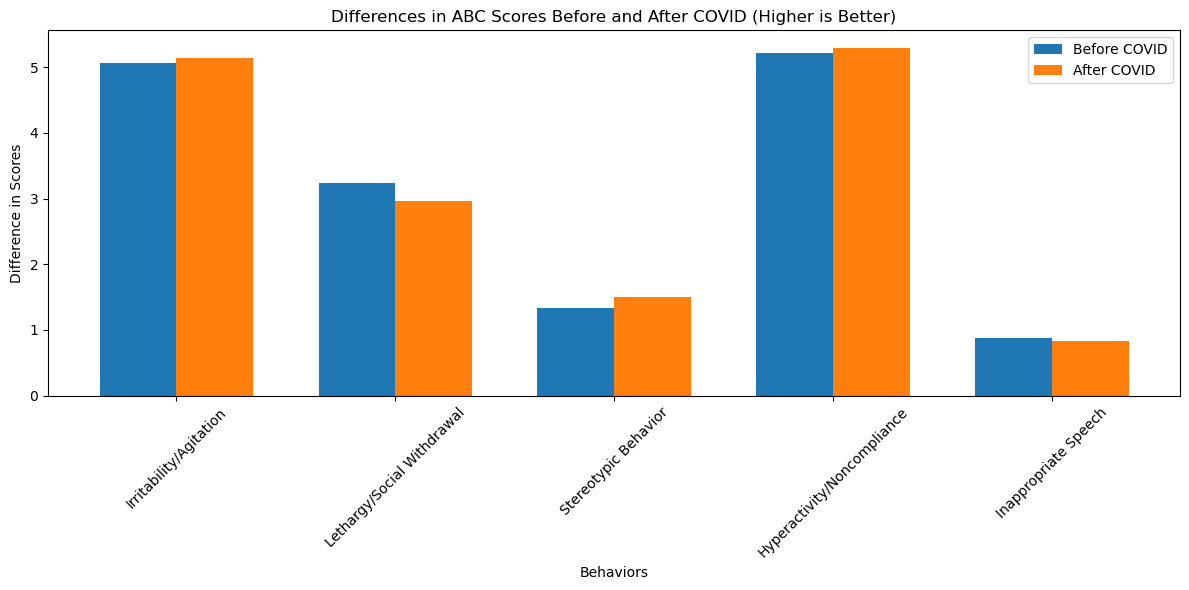

In [91]:

# Extract differences for before and after COVID
before_covid_diffs = before_covid_comparison['Difference (Before COVID)']
after_covid_diffs = after_covid_comparison['Difference (After COVID)']

# Define the behaviors
behaviors = before_covid_diffs.index

# Create a bar plot
plt.figure(figsize=(12, 6))
bar_width = 0.35
index = range(len(behaviors))

# Plot the differences
plt.bar(index, before_covid_diffs, bar_width, label='Before COVID')
plt.bar([i + bar_width for i in index], after_covid_diffs, bar_width, label='After COVID')

# Add labels and title
plt.xlabel('Behaviors')
plt.ylabel('Difference in Scores')
plt.title('Differences in ABC Scores Before and After COVID (Higher is Better)')
plt.xticks([i + bar_width / 2 for i in index], behaviors, rotation=45)
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [100]:
df_names = ['before_covid_data', 'before_covid_intake', 'before_covid_reevaluation', 'after_covid_data', 'after_covid_intake', 'after_covid_reevaluation']

In [92]:
pre_observations = before_covid_data.shape[0]
pre_intake_observations = before_covid_intake.shape[0]
pre_reeval_observations = before_covid_reevaluation.shape[0]

post_observations = after_covid_data.shape[0]
post_intake_observations = after_covid_intake.shape[0]
post_reeval_observations = after_covid_reevaluation.shape[0]

print(pre_observations)
print(pre_intake_observations)
print(pre_reeval_observations)
print()
print(post_observations)
print(post_intake_observations)
print(post_reeval_observations)


# print(before_covid_data.drop_duplicates('Local ID')['race_clean'].value_counts())
print(before_covid_intake['race_clean'].value_counts())

print(before_covid_reevaluation['race_clean'].value_counts())

8392
2299
6061

6484
907
5561
race_clean
White                               1339
Black/African American               441
Other/Unknown                        268
Hispanic/Latinx                      134
Asian/Pacific Islander                84
Mixed                                 21
American Indian or Alaska Native      12
Name: count, dtype: int64
race_clean
White                               3636
Black/African American              1409
Other/Unknown                        469
Hispanic/Latinx                      291
Asian/Pacific Islander               174
Mixed                                 50
American Indian or Alaska Native      32
Name: count, dtype: int64


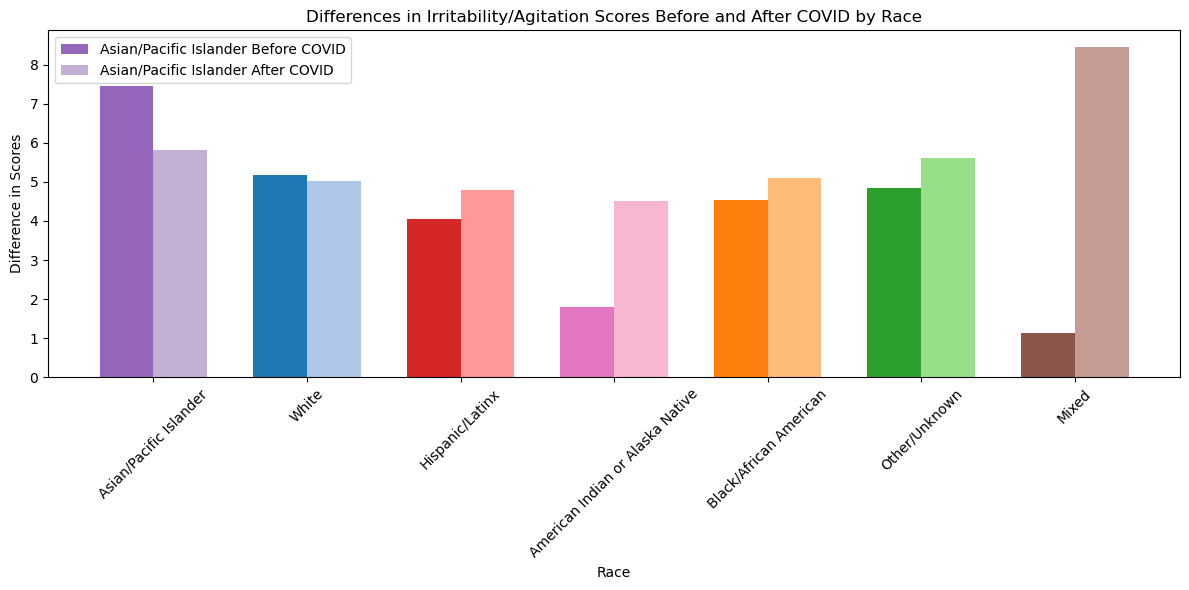

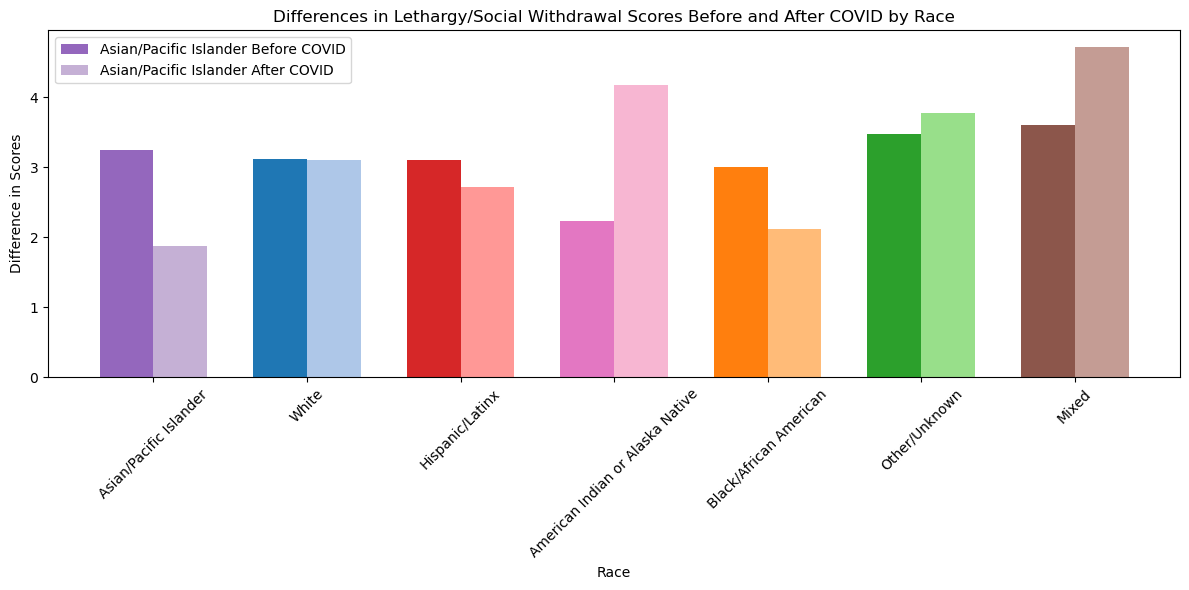

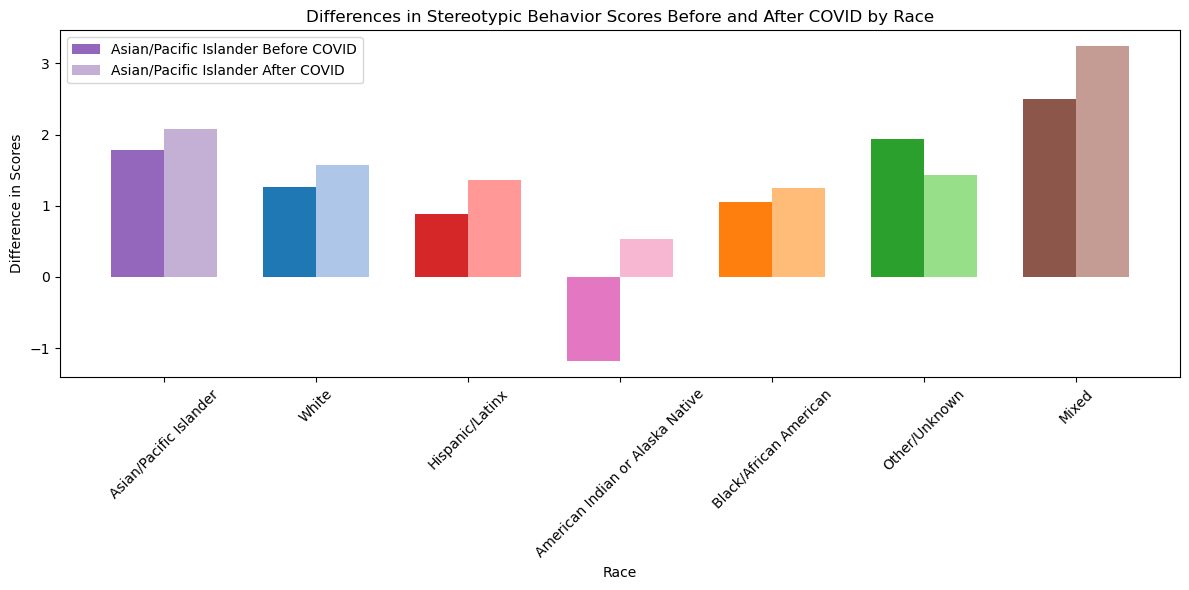

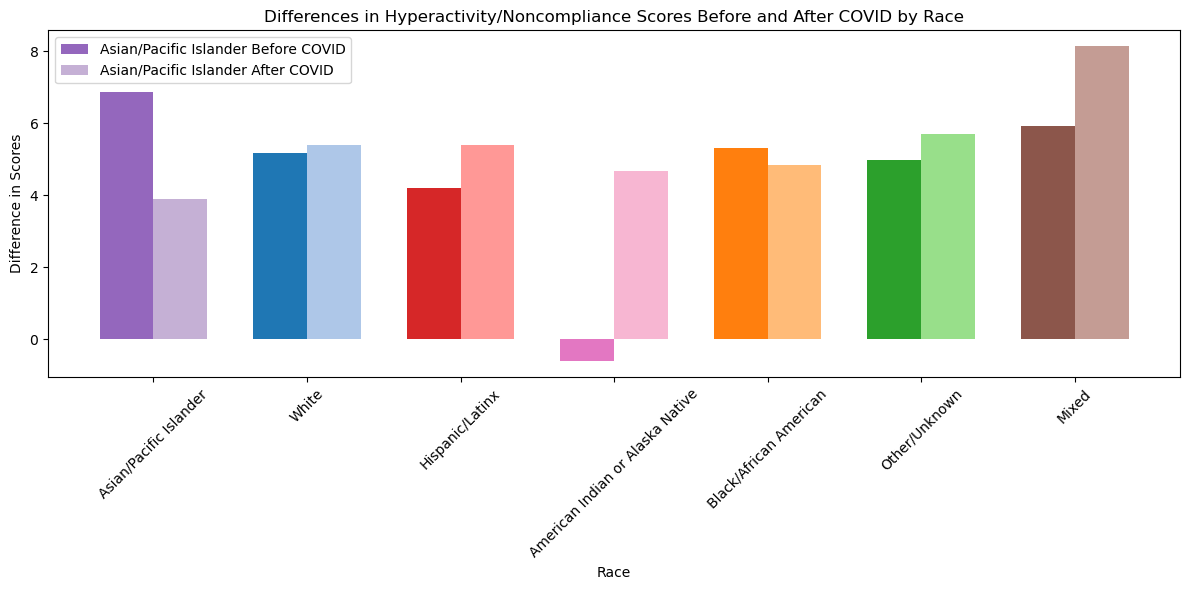

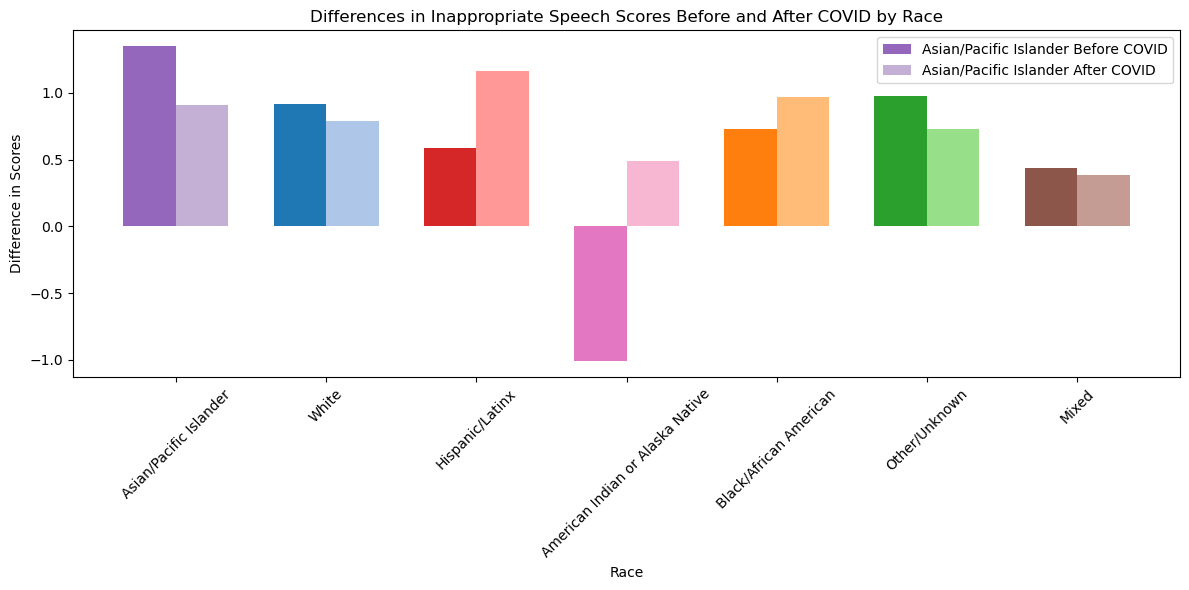

In [93]:
# Function to calculate differences in means before and after COVID for a specific race
def calculate_differences(df, behavior):
    intake_mean = df[df['Type of Service'] == 'Intake'][behavior].mean()
    reevaluation_mean = df[df['Type of Service'] == 'Re-evaluation'][behavior].mean()
    return intake_mean - reevaluation_mean

# Plot differences by race for each behavior
for behavior in behaviors:
    plt.figure(figsize=(12, 6))
    bar_width = 0.35
    index = range(len(races))

    for i, race in enumerate(races):
        # Filter data for the current race
        before_covid_race_data = before_covid_data[before_covid_data['race_clean'] == race]
        after_covid_race_data = after_covid_data[after_covid_data['race_clean'] == race]

        # Calculate differences
        before_covid_diff = calculate_differences(before_covid_race_data, behavior)
        after_covid_diff = calculate_differences(after_covid_race_data, behavior)
        
        # Plot the differences
        plt.bar(i, before_covid_diff, bar_width, color=colors[race][0], label=f'{race} Before COVID' if i == 0 else "")
        plt.bar(i + bar_width, after_covid_diff, bar_width, color=colors[race][1], label=f'{race} After COVID' if i == 0 else "")

    # Add labels and title
    plt.xlabel('Race')
    plt.ylabel('Difference in Scores')
    plt.title(f'Differences in {behavior} Scores Before and After COVID by Race')
    plt.xticks([i + bar_width / 2 for i in index], races, rotation=45)
    plt.legend()

    # Display the plot
    plt.tight_layout()
    plt.show()

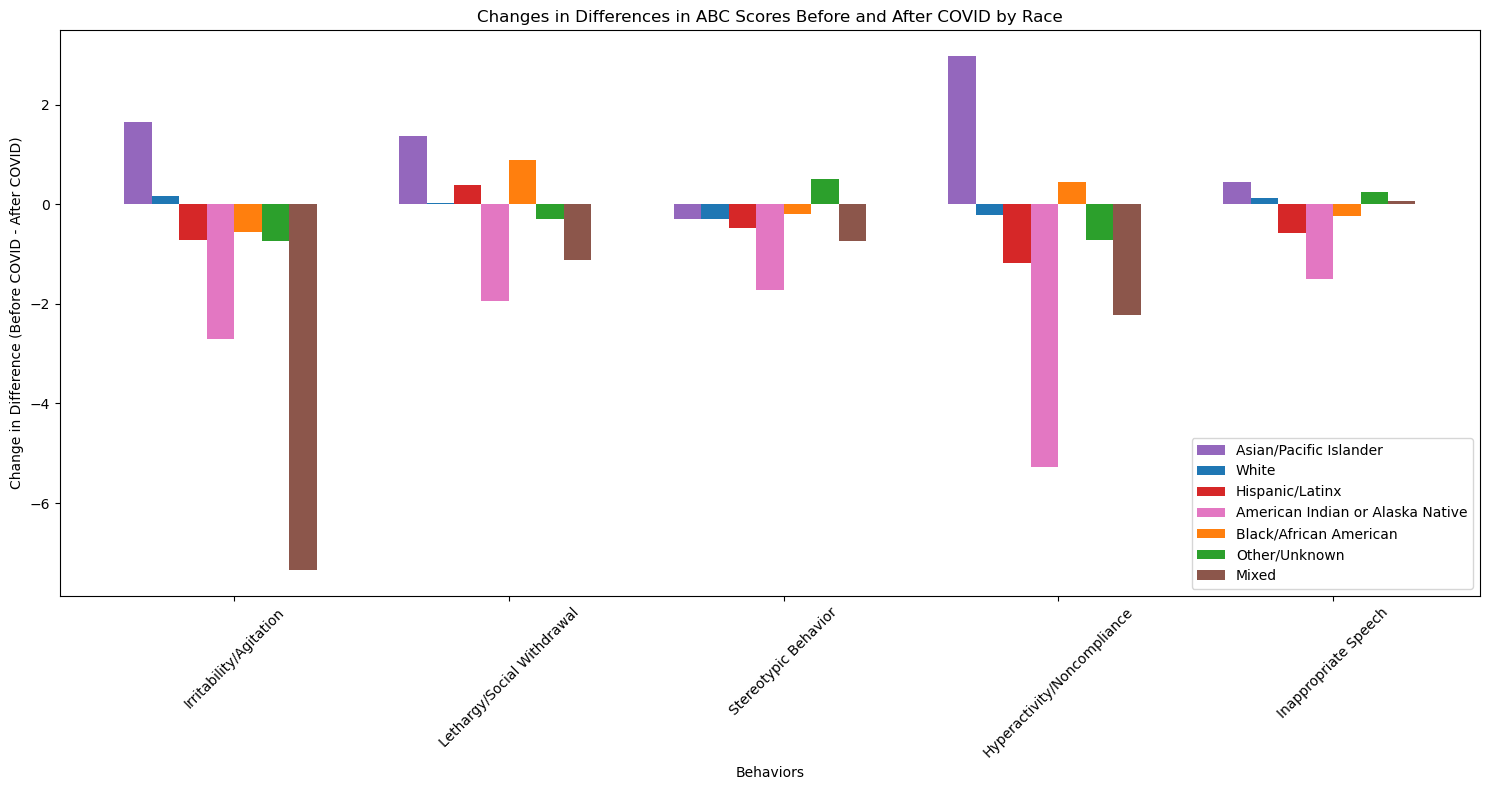

In [94]:
plt.figure(figsize=(15, 8))
bar_width = 0.1
index = range(len(behaviors))

for i, race in enumerate(races):
    change_in_difference = []
    
    # Filter data for the current race
    before_covid_race_data = before_covid_data[before_covid_data['race_clean'] == race]
    after_covid_race_data = after_covid_data[after_covid_data['race_clean'] == race]

    for behavior in behaviors:
        # Calculate differences
        before_covid_intake_mean = before_covid_race_data[before_covid_race_data['Type of Service'] == 'Intake'][behavior].mean()
        before_covid_reevaluation_mean = before_covid_race_data[before_covid_race_data['Type of Service'] == 'Re-evaluation'][behavior].mean()
        before_covid_diff = before_covid_intake_mean - before_covid_reevaluation_mean

        after_covid_intake_mean = after_covid_race_data[after_covid_race_data['Type of Service'] == 'Intake'][behavior].mean()
        after_covid_reevaluation_mean = after_covid_race_data[after_covid_race_data['Type of Service'] == 'Re-evaluation'][behavior].mean()
        after_covid_diff = after_covid_intake_mean - after_covid_reevaluation_mean
        
        # Calculate change in difference
        change_in_diff = before_covid_diff - after_covid_diff
        change_in_difference.append(change_in_diff)
    
    plt.bar([x + i * bar_width for x in index], change_in_difference, bar_width, color=colors[race][0], label=race)

# Add labels and title
plt.xlabel('Behaviors')
plt.ylabel('Change in Difference (Before COVID - After COVID)')
plt.title('Changes in Differences in ABC Scores Before and After COVID by Race')
plt.xticks([x + bar_width * len(races) / 2 for x in index], behaviors, rotation=45)
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [101]:
df_names

['before_covid_data',
 'before_covid_intake',
 'before_covid_reevaluation',
 'after_covid_data',
 'after_covid_intake',
 'after_covid_reevaluation']

In [108]:
sum_changes_df.index

Index(['Asian/Pacific Islander', 'White', 'Hispanic/Latinx',
       'American Indian or Alaska Native', 'Black/African American',
       'Other/Unknown', 'Mixed'],
      dtype='object')

In [109]:
colors

{'White': ('#1f77b4', '#aec7e8'),
 'Black/African American': ('#ff7f0e', '#ffbb78'),
 'Other/Unknown': ('#2ca02c', '#98df8a'),
 'Hispanic/Latinx': ('#d62728', '#ff9896'),
 'Asian/Pacific Islander': ('#9467bd', '#c5b0d5'),
 'Mixed': ('#8c564b', '#c49c94'),
 'American Indian or Alaska Native': ('#e377c2', '#f7b6d2')}

Sum of Changes DataFrame:                                   Sum of Changes
Asian/Pacific Islander                  6.124621
White                                  -0.205352
Hispanic/Latinx                        -2.578769
American Indian or Alaska Native      -13.150641
Black/African American                  0.340248
Other/Unknown                          -1.016133
Mixed                                 -11.369850


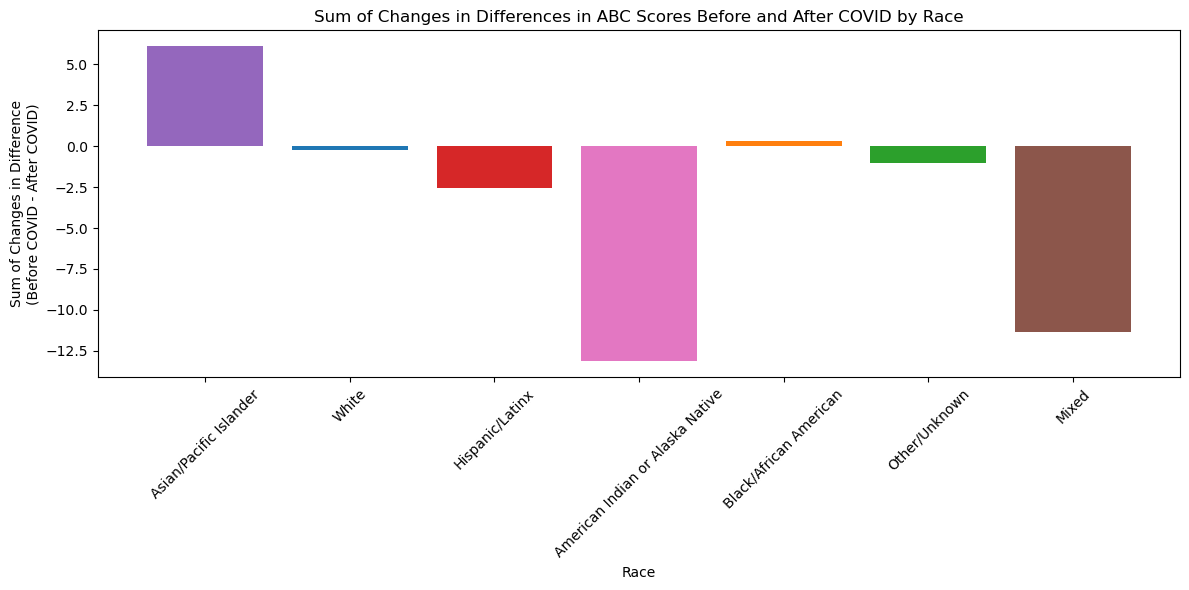

In [116]:
# Function to analyze differences by race and sum them
def analyze_and_sum_differences_by_race(race):
    race_data = merged_df[merged_df['race_clean'] == race]
    
    # Separate data into before and after COVID-19
    # before_covid_data = race_data[race_data['Date Reviewed'] < covid_onset_date]
    # after_covid_data = race_data[race_data['Date Reviewed'] >= covid_onset_date]

    # # Further separate into Intake and Re-evaluation for both periods
    # before_covid_intake1 = before_covid_data[before_covid_data['Type of Service'] == 'Intake']
    # before_covid_reevaluation1 = before_covid_data[before_covid_data['Type of Service'] == 'Re-evaluation']

    # after_covid_intake1 = after_covid_data[after_covid_data['Type of Service'] == 'Intake']
    # after_covid_reevaluation1 = after_covid_data[after_covid_data['Type of Service'] == 'Re-evaluation']

    before_covid_data1 = before_covid_data[before_covid_data['race_clean'] == race]
    before_covid_intake1 = before_covid_intake[before_covid_intake['race_clean'] == race]
    before_covid_reevaluation1 = before_covid_reevaluation[before_covid_reevaluation['race_clean'] == race]
    after_covid_data1 = after_covid_data[after_covid_data['race_clean'] == race]
    after_covid_intake1 = after_covid_intake[after_covid_intake['race_clean'] == race]
    after_covid_reevaluation1 = after_covid_reevaluation[after_covid_reevaluation['race_clean'] == race]
        
    # Calculate the mean scores for each behavior at Intake and Re-evaluation for both periods
    before_covid_intake_means = before_covid_intake1.mean(numeric_only=True)
    before_covid_reevaluation_means = before_covid_reevaluation1.mean(numeric_only=True)

    after_covid_intake_means = after_covid_intake1.mean(numeric_only=True)
    after_covid_reevaluation_means = after_covid_reevaluation1.mean(numeric_only=True)

    # Combine the means into DataFrames for comparison
    before_covid_comparison = pd.DataFrame({
        'Intake Mean (Before COVID)': before_covid_intake_means,
        'Re-evaluation Mean (Before COVID)': before_covid_reevaluation_means
    })
    before_covid_comparison['Difference (Before COVID)'] = before_covid_comparison['Intake Mean (Before COVID)'] - before_covid_comparison['Re-evaluation Mean (Before COVID)']

    after_covid_comparison = pd.DataFrame({
        'Intake Mean (After COVID)': after_covid_intake_means,
        'Re-evaluation Mean (After COVID)': after_covid_reevaluation_means
    })
    after_covid_comparison['Difference (After COVID)'] = after_covid_comparison['Intake Mean (After COVID)'] - after_covid_comparison['Re-evaluation Mean (After COVID)']

    # Calculate the change in difference
    change_in_difference = before_covid_comparison['Difference (Before COVID)'] - after_covid_comparison['Difference (After COVID)']

    # Sum the changes in difference across all behaviors
    sum_change_in_difference = change_in_difference.sum()

    return sum_change_in_difference


# Calculate the sum of changes in differences for each race
sum_changes_by_race = {race: analyze_and_sum_differences_by_race(race) for race in races}

# Convert the result to a DataFrame for plotting
sum_changes_df = pd.DataFrame.from_dict(sum_changes_by_race, orient='index', columns=['Sum of Changes'])

# Debugging step: Print the DataFrame
print("Sum of Changes DataFrame:", sum_changes_df)

# Plot the sums of changes in differences by race with colors
plt.figure(figsize=(12, 6))
plt.bar(sum_changes_df.index, sum_changes_df['Sum of Changes'], color=[colors[race][0] for race in sum_changes_df.index])
# plt.bar(sum_changes_df.index, sum_changes_df['Sum of Changes'])

# Add labels and title
plt.xlabel('Race')
plt.ylabel('Sum of Changes in Difference\n(Before COVID - After COVID)')
plt.title('Sum of Changes in Differences in ABC Scores Before and After COVID by Race')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
# # Function to analyze differences by race and calculate confidence intervals
# def analyze_and_calculate_ci_by_race(race):
#     race_data = merged_df[merged_df['race_clean'] == race]
    
#     # Separate data into before and after COVID-19
#     before_covid_data = race_data[race_data['Date Reviewed'] < covid_onset_date]
#     after_covid_data = race_data[race_data['Date Reviewed'] >= covid_onset_date]

#     # Further separate into Intake and Re-evaluation for both periods
#     before_covid_intake = before_covid_data[before_covid_data['Type of Service'] == 'Intake']
#     before_covid_reevaluation = before_covid_data[before_covid_data['Type of Service'] == 'Re-evaluation']

#     after_covid_intake = after_covid_data[after_covid_data['Type of Service'] == 'Intake']
#     after_covid_reevaluation = after_covid_data[after_covid_data['Type of Service'] == 'Re-evaluation']

#     # Calculate the mean scores for each behavior at Intake and Re-evaluation for both periods
#     before_covid_intake_means = before_covid_intake.mean(numeric_only=True)
#     before_covid_reevaluation_means = before_covid_reevaluation.mean(numeric_only=True)

#     after_covid_intake_means = after_covid_intake.mean(numeric_only=True)
#     after_covid_reevaluation_means = after_covid_reevaluation.mean(numeric_only=True)

#     # Combine the means into DataFrames for comparison
#     before_covid_comparison = pd.DataFrame({
#         'Intake Mean (Before COVID)': before_covid_intake_means,
#         'Re-evaluation Mean (Before COVID)': before_covid_reevaluation_means
#     })
#     before_covid_comparison['Difference (Before COVID)'] = before_covid_comparison['Intake Mean (Before COVID)'] - before_covid_comparison['Re-evaluation Mean (Before COVID)']

#     after_covid_comparison = pd.DataFrame({
#         'Intake Mean (After COVID)': after_covid_intake_means,
#         'Re-evaluation Mean (After COVID)': after_covid_reevaluation_means
#     })
#     after_covid_comparison['Difference (After COVID)'] = after_covid_comparison['Intake Mean (After COVID)'] - after_covid_comparison['Re-evaluation Mean (After COVID)']

#     # Calculate the change in difference
#     change_in_difference = before_covid_comparison['Difference (Before COVID)'] - after_covid_comparison['Difference (After COVID)']

#     # Sum the changes in difference across all behaviors
#     sum_change_in_difference = change_in_difference.sum()

#     # Calculate the confidence interval
#     n = len(change_in_difference)
#     std_err = stats.sem(change_in_difference)
#     h = std_err * stats.t.ppf((1 + 0.95) / 2, n - 1)

#     return sum_change_in_difference, h

# # Calculate the sum of changes in differences and confidence intervals for each race
# sum_changes_ci_by_race = {race: analyze_and_calculate_ci_by_race(race) for race in races}

# # Convert the result to a DataFrame for plotting
# sum_changes_df = pd.DataFrame(sum_changes_ci_by_race, index=['Sum of Changes', 'CI']).T

# # Plot the sums of changes in differences by race with specified colors and confidence intervals
# plt.figure(figsize=(12, 6))
# bars = plt.bar(sum_changes_df.index, sum_changes_df['Sum of Changes'], color=[colors[race][0] for race in sum_changes_df.index], yerr=sum_changes_df['CI'], capsize=5)

# # Add labels and title
# plt.xlabel('Race')
# plt.ylabel('Sum of Changes in Difference\n(Before COVID - After COVID)')
# plt.title('Sum of Changes in Differences in ABC Scores Before and After COVID by Race')
# plt.xticks(rotation=45)
# plt.tight_layout()

# # Display the plot
# plt.show()

In [117]:
# testing how we could match up differences based on Client_ID
# intake_mixed = merged_df[(merged_df['race_clean'] == 'Mixed') & (merged_df['Type of Service'] == 'Intake')]
# reeval_mixed = merged_df[(merged_df['race_clean'] == 'Mixed') & (merged_df['Type of Service'] != 'Intake')]

intake_merged = merged_df[(merged_df['Type of Service'] == 'Intake')]
reeval_merged = merged_df[(merged_df['Type of Service'] != 'Intake')]

merged_byclient = intake_merged.merge(reeval_merged, how='left', on='Local ID')

merged_byclient['irrit_diff'] = merged_byclient['Irritability/Agitation_x'] - merged_byclient['Irritability/Agitation_y']
merged_byclient['leth_diff'] = merged_byclient['Lethargy/Social Withdrawal_x'] - merged_byclient['Lethargy/Social Withdrawal_y']
merged_byclient['stereo_diff'] = merged_byclient['Stereotypic Behavior_x'] - merged_byclient['Stereotypic Behavior_y']
merged_byclient['hyper_diff'] = merged_byclient['Hyperactivity/Noncompliance_x'] - merged_byclient['Hyperactivity/Noncompliance_y']
merged_byclient['inapp_diff'] = merged_byclient['Inappropriate Speech_x'] - merged_byclient['Inappropriate Speech_y']



merged_mixed_means = merged_byclient.mean(numeric_only=True)
merged_mixed_means

merged_byclient['total_diff'] = (merged_byclient['irrit_diff'] +
                              merged_byclient['leth_diff'] +
                              merged_byclient['stereo_diff'] +
                              merged_byclient['hyper_diff'] +
                              merged_byclient['inapp_diff'])

In [119]:
merged_df1

NameError: name 'merged_df1' is not defined

In [118]:
merged_df1.keys()

NameError: name 'merged_df1' is not defined

In [7]:

from linearmodels.panel import PanelOLS
import statsmodels.api as sm
import statsmodels.formula.api as smf

modified_df = merged_df1.rename(columns={'Irritability/Agitation': 'Irritability_Agitation'})

# Define the formula for PanelOLS
formula = "Irritability_Agitation ~ 1 + covid_period + C(race_clean) + C(Type_of_Service) + EntityEffects"

# Create the PanelOLS model
model = PanelOLS.from_formula(formula, data=modified_df)

# Fit the model
results = model.fit()

# Print the results summary
print(results)

NameError: name 'merged_df1' is not defined

In [ ]:
merged_df1

In [ ]:


# Example DataFrame structure
# merged_df should include columns: 'Individual_ID', 'Date_Reviewed', 'Type_of_Service', 'Score', 'race_clean', 'Period'
# 'Period' should be 0 for pre-COVID and 1 for post-COVID

# Ensure the data is sorted by individual and date
merged_df = merged_df.sort_values(by=['Local ID', 'Date_Reviewed'])

# Set the index to be a MultiIndex with 'Individual_ID' and 'Date_Reviewed'
merged_df = merged_df.set_index(['Local ID', 'Date_Reviewed'])

# Create dummy variables for 'Type_of_Service' and 'race_clean'
merged_df = pd.get_dummies(merged_df, columns=['Type of Service', 'race_clean'], drop_first=True)

# Specify the dependent variable and independent variables
y = merged_df['Score']
X = merged_df[['Period', 'Type_of_Service_Re-evaluation', 'race_clean_1', 'race_clean_2']] # Adjust for actual dummy variables

# Add a constant to the independent variables
X = sm.add_constant(X)

# Fit the fixed effects model
model = PanelOLS(y, X, entity_effects=True)
fe_res = model.fit()

# Print the results
print(fe_res.summary)


In [17]:
#descriptive analysis code

demographics_df['Local ID'].nunique()

4986

In [16]:
abc_data['Local ID'].nunique()

8071

In [19]:
num_indv = merged_df['Local ID'].nunique()

In [39]:
before_covid_intake['Local ID'].nunique()

1345

In [40]:
after_covid_intake.shape[0]

885

In [35]:
before_covid_reevaluation.shape[0]

3761

In [34]:
after_covid_reevaluation.shape[0]

5561